In [1]:
import polars as pl
from statsmodels.formula import api as smf

Read datasets as downloaded from [kaggle](https://www.kaggle.com/datasets/rohanrao/formula-1-world-championship-1950-2020).
The dataset contains all races up until about the half of the 2023 season.

In [2]:
results = pl.read_csv("data/raw/results.csv", ignore_errors=True)
status = pl.read_csv("data/raw/status.csv")
drivers = pl.read_csv("data/raw/drivers.csv")
races = pl.read_csv("data/raw/races.csv")
constructors = pl.read_csv("data/raw/constructors.csv")

# save current seasons driver for later use
latest_season = races.filter(pl.col("year") == pl.col("year").max()).get_column("raceId").unique()
current_drivers = results.filter(pl.col("raceId").is_in(latest_season)).get_column("driverId").unique()
current_drivers_names = drivers.filter(pl.col("driverId").is_in(current_drivers)).with_columns(
    name = pl.col("forename") + " " + pl.col("surname")
).get_column("name").unique()

Since our model will try to predict the finishing position, we introduce a dummy variable to account for retirements from the race that the driver had no fault in. 
These are mostly techinical failures.
There are some categories which have som abiguity even after researching the specific races details.

In [3]:
not_self_responsible_dnf = [
    # mechanical failures
    "Chassis",
    "Ignition",
    "Engine",
    "Gearbox",
    "Transmission",
    "Clutch",
    "Hydraulics",
    "Electrical",
    "Radiator",
    "Suspension",
    "Brakes",
    "Differential",
    "Overheating",
    "Mechanical",
    "Tyre",
    "Driver Seat",
    "Puncture",
    "Driveshaft",
    "Fuel pressure",
    "Front wing",
    "Water pressure",
    "Refuelling",
    "Wheel",
    "Throttle",
    "Steering",
    "Technical",
    "Electronics",
    "Broken wing",
    "Heat shield fire",
    "Exhaust",
    "Oil leak",
    "Wheel rim",
    "Water leak",
    "Fuel pump",
    "Track rod",
    "Oil pressure",
    "Engine fire",
    "Engine misfire",
    "Tyre puncture",
    "Out of fuel",
    "Wheel nut",
    "Pneumatics",
    "Rear wing",
    "Fire",
    "Wheel bearing",
    "Fuel system",
    "Oil line",
    "Fuel rig",
    "Launch control",
    "Fuel",
    "Power loss",
    "Vibrations",
    "Safety",
    "Drivetrain",
    "Ignition"
    "Chassis",
    "Battery",
    "Halfshaft",
    "Crankshaft",
    "Alternator",
    "Underweight",
    "Safety belt",
    "Oil pump",
    "Fuel leak",
    "Injection",
    "Distributor",
    "Turbo",
    "CV joint",
    "Water pump",
    "Spark plugs",
    "Fuel pipe",
    "Oil pipe",
    "Axle",
    "Water pipe",
    "Magneto",
    "Supercharger",
    "Power Unit",
    "ERS",
    "Brake duct",
    "Seat",
    "Undertray",
    "Cooling system",
    # ambiguous
    "Disqualified", # includes driver erros but many team errors
    "Retired", # some due to technical, some after collisions
    "Excluded", # usually team failing to follow regulations
    # found nothing on wikipedia indicating driver error
    "Safety concerns", 
    "Handling",
    "Physical",
    # let's not blame the victims
    "Injury",
    "Fatal accident",
    "Eye injury", # Helmut Marko for no fault of his own 
    "Injured", # relates to injuries sustained before the race
    "Injury", # relates to injuries sustained before the race
    "Illness", # nothing to do with driver skill
    "Driver unwell", # not related to skill
]

These DNF reasons are treated as being the drivers fault:

In [4]:
status.filter((~pl.col("status").is_in(not_self_responsible_dnf)) & (~pl.col("status").str.contains("Lap")))["status"].unique().to_list()

['Collision',
 'Withdrew',
 'Not classified',
 '107% Rule',
 'Stalled',
 'Damage',
 'Finished',
 'Spun off',
 'Not restarted',
 'Did not qualify',
 'Accident',
 'Did not prequalify',
 'Collision damage',
 'Debris']

In [5]:
finishing_position = "positionOrder"
df = (
    results
    # remove drivers with multiple entries per race and use their best
    .sort(["raceId", "driverId", finishing_position])
    .unique(["raceId", "driverId"], keep="first")
    # build feature dnf
    .join(status, on="statusId", how="left")
    .with_columns(
        pl.col("status").is_in(not_self_responsible_dnf).alias("technical_dnf"),
    )
    # build target
    .with_columns(pl.col(finishing_position).max().over("raceId").alias(f"{finishing_position}_last"))
    .with_columns(
        score = 1 - ((pl.col(finishing_position) - 1) / (pl.col(f"{finishing_position}_last") - 1)),
    )
    # join more data
    .join(drivers, on="driverId", how="left")
    .join(races, on="raceId", how="left")
    # remove indianapolis 500
    .filter(~pl.col("name").str.contains("Indianapolis 500"))
    # indianapolis 2005 - michelin scandal
    .filter(pl.col("raceId") != 79)
    # remove drivers with not enough experience
    .filter(pl.col("raceId").n_unique().over("driverId") > 20)
    # build more human readable names
    .with_columns(
        race=pl.col("year").cast(pl.Utf8) + " " + pl.col("name"),
        driver=pl.col("forename") + " " + pl.col("surname"),
    )
    # build car info
    .join(constructors, on="constructorId", how="left", suffix="_constructor")
    .with_columns(
        car=pl.col("year").cast(pl.Utf8)  +" "+ pl.col("name_constructor"),
    )
    # remove drivers who drive too few different cars
    .filter(pl.col("car").n_unique().over("driver") > 1)
    # remove cars used too rarely
    .filter(pl.col("raceId").n_unique().over("car") > 1)
    # reduce columns
    .select(["raceId", "driverId", "race", "driver", "car", "technical_dnf", "score"])
).to_pandas().set_index(["raceId", "driverId", "race"])

Here is an example of the dataset used for modeling.
Most interesting is the `score` variable, which describes a drivers finishing position.
A value of `score=0` means the driver finished last.
A value of `score=1` means the driver won the race.
The model will try to preidct this `score`.
The idea is that the finishing position is a good dependent variable when evalutating talent - if analysed together with other mitigating factors.
Most importantly those include the `car` and eventual techinical failures of the car `techincal_dnf`.
This is inspired by the method established in [this paper](https://www.researchgate.net/publication/228310743)'s section 3.

By furthermore restricting the `score` to `[0, 1]` we account for the fact that finishing 5th in a race of 10 competitors is a different achievement than finishing 5th in a race of 20.

In [6]:
df.loc[1].sort_values("score", ascending=False)

,,driver,car,technical_dnf,score
driverId,race,,,,
18,2009 Australian Grand Prix,Jenson Button,2009 Brawn,False,1.000000
22,2009 Australian Grand Prix,Rubens Barrichello,2009 Brawn,False,0.947368
15,2009 Australian Grand Prix,Jarno Trulli,2009 Toyota,False,0.894737
10,2009 Australian Grand Prix,Timo Glock,2009 Toyota,False,0.842105
4,2009 Australian Grand Prix,Fernando Alonso,2009 Renault,False,0.789474
3,2009 Australian Grand Prix,Nico Rosberg,2009 Williams,False,0.736842
67,2009 Australian Grand Prix,Sébastien Buemi,2009 Toro Rosso,False,0.684211
7,2009 Australian Grand Prix,Sébastien Bourdais,2009 Toro Rosso,False,0.631579
16,2009 Australian Grand Prix,Adrian Sutil,2009 Force India,False,0.578947


This datasaset can the be used to fit a model predicting the score value:

In [7]:
model = smf.logit("score ~ driver + car + technical_dnf - 1", df).fit()

Optimization terminated successfully.
         Current function value: 0.546115
         Iterations 9


The models parameters will be our indicator to figure out the greatest of all time - both drivers and cars.

One obvious weakness of the model is that it assumes a somewhat constant driver performance over all years.
This can become a problem for some cases, which are discussed in the source code comments above.

In [8]:
res = model.summary2().tables[1]
drivers = res.index.str.startswith("driver")
cars = res.index.str.startswith("car")

First a reality checks for the dummy variable, which should be very cleary negative.

In [9]:
res.loc[~drivers & ~cars]

,Coef.,Std.Err.,z,P>|z|,[0.025,0.975]
technical_dnf[T.True],-1.357703,0.037,-36.694499,8.937980e-295,-1.430222,-1.285184


Since a modern grid contains 20 drivers, we will show the top 20 for an all-star grid.
For the cars, we are only concerned with a top 10.

In [10]:
res.loc[drivers].sort_values("Coef.", ascending=False).head(20)

,Coef.,Std.Err.,z,P>|z|,[0.025,0.975]
driver[Juan Fangio],2.018795,0.783497,2.576646,0.009976,0.483169,3.554422
driver[Jim Clark],1.868246,0.950878,1.964758,0.049442,0.004558,3.731933
driver[Max Verstappen],1.796268,1.031320,1.741718,0.081558,-0.225081,3.817618
driver[Lando Norris],1.770871,1.062493,1.666713,0.095571,-0.311577,3.853320
driver[Jackie Stewart],1.753566,0.960713,1.825276,0.067959,-0.129397,3.636528
driver[Emerson Fittipaldi],1.690771,0.968762,1.745291,0.080934,-0.207967,3.589510
driver[Charles Leclerc],1.679115,1.041414,1.612342,0.106887,-0.362018,3.720249
driver[Fernando Alonso],1.616219,0.989468,1.633423,0.102380,-0.323102,3.555540
driver[Dan Gurney],1.596554,0.930588,1.715640,0.086228,-0.227365,3.420473
driver[Carlos Sainz],1.596006,1.028882,1.551204,0.120853,-0.420565,3.612577


And the winner is **Juan Manuel Fangio**!
His rating is greatly helped by the fact he consistently won in a selection of different a great number of team mates.
This is - one could argue - a feat of the true greats.

Even though Lewis Hamilton is by number of victories and title clearly the most successful driver of all time, he ranks fairly low in this analysis.
This can be explained by looking at the cars scores.
Many of the cars with the strongest rating were driven by Hamilton in his dominant years.

This highlights another difficulty when evaluating driver performance:
A driver can only ever be truly judged against his team mate.
But if the team mate is perfroming on a high level as well it is difficult to judge of the results are mainly determined by the drivers skills or the cars performance.
Hamilton had strong team mates for most of his career including 3 drivers champions (Fernando Alonso, Jenson Button, Nico Rosberg).
Another prominent example are Ayrton Senna and Alain Prost who competed alongside each other in McLaren.

In [11]:
res.loc[cars].sort_values("Coef.", ascending=False).head(10)

,Coef.,Std.Err.,z,P>|z|,[0.025,0.975]
car[T.1954 Mercedes],1.390635,2.448274,0.568006,0.570031,-3.407894,6.189163
car[T.1988 McLaren],1.185909,1.144386,1.036284,0.300070,-1.057046,3.428864
car[T.2017 Mercedes],0.933274,1.117415,0.835208,0.403601,-1.256819,3.123366
car[T.2019 Mercedes],0.897022,1.109238,0.808683,0.418697,-1.277044,3.071089
car[T.2011 Red Bull],0.887051,1.124002,0.789190,0.430001,-1.315953,3.090054
car[T.2023 Red Bull],0.820950,1.231313,0.666728,0.504946,-1.592378,3.234278
car[T.1991 McLaren],0.816256,1.071924,0.761487,0.446366,-1.284676,2.917188
car[T.1979 Ferrari],0.790458,1.103171,0.716532,0.473663,-1.371718,2.952634
car[T.2000 McLaren],0.748492,1.083436,0.690850,0.489660,-1.375004,2.871988
car[T.1990 Benetton],0.738599,1.064722,0.693702,0.487869,-1.348217,2.825416


The graph below compares the models predictions with observed race results.
The black diagonal marks where predictions and results exactly match.
All result above indicate a driver performing above expectations.
All results below indicate a driver performing below expectations.

This visualization also allows to see the most dominant driver + car pairings over the years.
The more to the right, the higher a combination scores.

Undisputed leader is Juan Manuel Fangio in his 1954 Mercedes.
Quite a bit off in second is Max Verstappen in 2023 (this analysis was done mid season 2023, so probably subject to change).
A close third is Alain Prost in his 1988 McLaren.
This is followed by Lewis Hamilton in his 2017 and 2019 Mercedes.

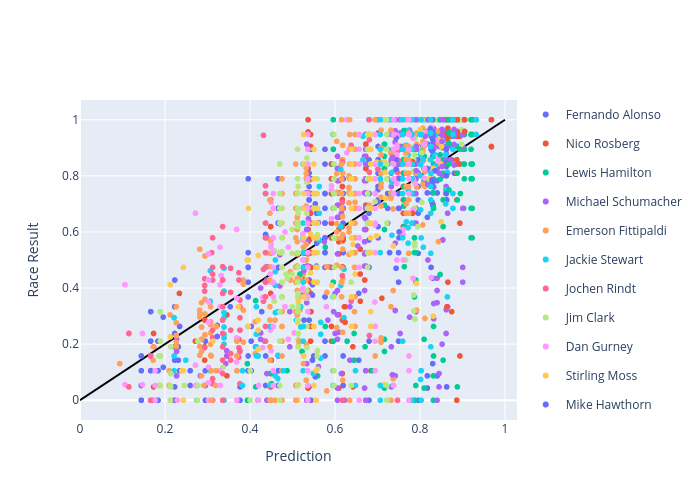

In [12]:
from plotly import express as px
import plotly.graph_objects as go

goats = list(res.loc[drivers].sort_values("Coef.", ascending=False).head(20).index.str.replace("driver[", "").str.replace("]", ""))
goats = df[df["driver"].isin(goats)]

fig1 = px.scatter(
    y=goats["score"],
    x=model.predict(goats),
    color=goats["driver"],
    hover_name=goats.reset_index()["race"],
)
fig2 = px.line((0,1), (0,1),color_discrete_sequence=["black"])
fig3 = go.Figure(data=fig1.data + fig2.data)
fig3.update_xaxes(title_text="Prediction")
fig3.update_yaxes(title_text="Race Result")
fig3.show(renderer="png")

And for a bit of controversy lets look at the current grid ranked by this algorithm:

In [13]:
res.loc[drivers & res.index.str.contains("|".join(current_drivers_names))].sort_values("Coef.", ascending=False)

,Coef.,Std.Err.,z,P>|z|,[0.025,0.975]
driver[Max Verstappen],1.796268,1.031320,1.741718,0.081558,-0.225081,3.817618
driver[Lando Norris],1.770871,1.062493,1.666713,0.095571,-0.311577,3.853320
driver[Charles Leclerc],1.679115,1.041414,1.612342,0.106887,-0.362018,3.720249
driver[Fernando Alonso],1.616219,0.989468,1.633423,0.102380,-0.323102,3.555540
driver[Carlos Sainz],1.596006,1.028882,1.551204,0.120853,-0.420565,3.612577
driver[Lewis Hamilton],1.547760,0.998623,1.549894,0.121167,-0.409506,3.505026
driver[Daniel Ricciardo],1.469464,1.022015,1.437811,0.150488,-0.533648,3.472576
driver[Alexander Albon],1.389130,1.081959,1.283903,0.199176,-0.731470,3.509729
driver[George Russell],1.342449,1.068597,1.256272,0.209017,-0.751963,3.436861
driver[Esteban Ocon],1.330650,1.019921,1.304660,0.192009,-0.668359,3.329658
